In [1]:
import numpy as np
import pandas as pd

churn = pd.read_csv('Proj-Customer-Churn.csv')
churn.loc[churn.TotalCharges == ' ', 'TotalCharges'] = None

categoricals = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
quants = ['tenure', 'MonthlyCharges', 'TotalCharges']

churn['Churn'] = churn['Churn'].astype('category')

for i in categoricals:
    churn[i] = churn[i].astype('category')
for j in quants:
    churn[j] = churn[j].astype('float64')

churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   float64 
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

Some of the above may not be useful. For example, Total Charges is likely just a fucntion of tenure and monthly charges. A quick look at a scatterplot comparing Total Charges to Tenure times Monthly Charges confirms this - since there are missing values in this column but not others, it's best to just get rid of it. Customer Id can also be removed.

The correlation coefficient between Monthly Charges times Tenure and Total Charges is 0.9996


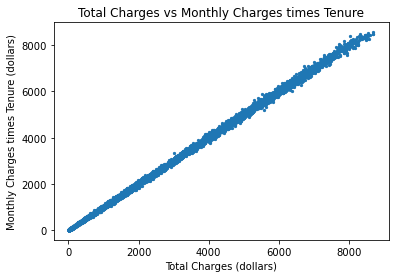

In [2]:
from matplotlib import pyplot as plt

churn_rmna = churn.dropna(axis = 0).copy()
x = churn_rmna.TotalCharges
y = churn_rmna.MonthlyCharges * churn_rmna.tenure

print('The correlation coefficient between Monthly Charges times Tenure and Total Charges is {}'.format(
    round(np.corrcoef(x, y)[0][1],4)))
plt.scatter(x, y, alpha = 1, s = 5);
plt.title("Total Charges vs Monthly Charges times Tenure")
plt.xlabel("Total Charges (dollars)")
plt.ylabel("Monthly Charges times Tenure (dollars)");

In [3]:
churn.drop(['TotalCharges', 'customerID'], axis=1, inplace = True)

In [4]:
# For consistency's sake, we will convert the 0s and 1s to No and Yes to match other categories
churn['SeniorCitizen'].replace(0, 'No', inplace = True)
churn['SeniorCitizen'].replace(1, 'Yes', inplace = True)

X = churn.iloc[:,0:18]
y = churn.iloc[:,18]

To explore possible simplifications we create and initial training and testing datasets to look at relationships between our predictors and responses

In [5]:
from sklearn.model_selection import train_test_split

seed = np.random.randint(1,1000000)
np.random.seed(seed)
initial_train_X, initial_test_X, initial_train_y, initial_test_y = train_test_split(X, y, test_size=0.4)

The remaining two quantitative predictors are shown below

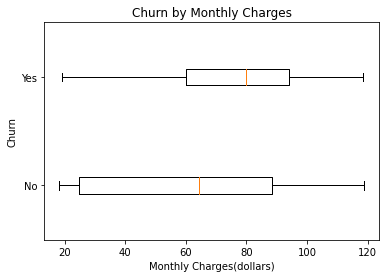

In [6]:
monthly = {'No':initial_train_X[initial_train_y == 'No'].MonthlyCharges, 
           'Yes':initial_train_X[initial_train_y == 'Yes'].MonthlyCharges}

ax = plt.axes() 
ax.boxplot(monthly.values(), vert=False)
ax.set_yticklabels(monthly.keys())
ax.set_ylabel('Churn')
ax.set_xlabel('Monthly Charges(dollars)');
ax.set_title('Churn by Monthly Charges');

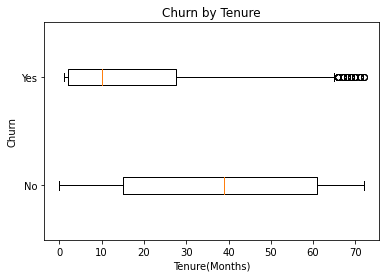

In [7]:
tenure = {'No':initial_train_X[initial_train_y == 'No'].tenure, 
           'Yes':initial_train_X[initial_train_y == 'Yes'].tenure}

# Plot the boxplot using the dictionary keys as the x labels
ax = plt.axes() 
ax.boxplot(tenure.values(), vert=False)
ax.set_yticklabels(tenure.keys())
ax.set_ylabel('Churn')
ax.set_xlabel('Tenure(Months)')
ax.set_title('Churn by Tenure');

In [8]:
# In order to simplify the model and only deal with categorical values cutoffs were derived to categorize customers
# as long term customers and customer who pay high rates

# for long term customers
churn.loc[churn['tenure'] >= 20, 'LT_customer'] = 'Yes'
churn.loc[churn['tenure'] < 20, 'LT_customer'] = 'No'
churn['LT_customer'] = churn['LT_customer'].astype('category')

# for customers with high monthly rates
churn.loc[churn['MonthlyCharges'] >= 60, 'High_rates'] = 'Yes'
churn.loc[churn['MonthlyCharges'] < 60, 'High_rates'] = 'No'
churn['High_rates'] = churn['High_rates'].astype('category')

# remove the quantitative features
churn.drop(['MonthlyCharges', 'tenure'], axis=1, inplace = True)

# Assign X and y
X = churn.drop(['Churn'], axis=1)
y = churn['Churn']

In [9]:
# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# Function for converting the categorical values to numerics to prepare for the ML algorithm

def convert_to_value(X, y):
    inputs = OrdinalEncoder()
    inputs.fit(X)
    outputs = LabelEncoder()
    outputs.fit(y)
    X_val = inputs.transform(X)
    y_val = outputs.transform(y)
    return X_val, y_val

In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training and testing dataset (seed set the same as above so as to assign in the same fashion)
np.random.seed(seed)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4)

# Use the function convert the test and training datasets
test_X_cd, test_y_cd = convert_to_value(test_X, test_y)
train_X_cd, train_y_cd = convert_to_value(train_X, train_y)

# Full Models
The following section contains the full models for 4 different models:
- Naive Bayes
- Logistic Regression
- Decision Trees
- Random Forest

### Naive Bayes - Full Model

The accuracy of the Naive Bayes model with all features is 0.741


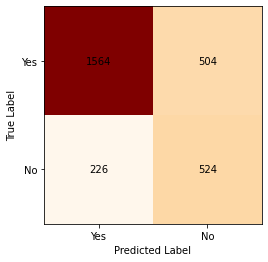

In [11]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

model = BernoulliNB()
model.fit(train_X_cd, train_y_cd)
predictions = model.predict(test_X_cd)

acc_fm_nb = model.score(test_X_cd, test_y_cd)

print('The accuracy of the Naive Bayes model with all features is {}'.format(
    round(acc_fm_nb,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

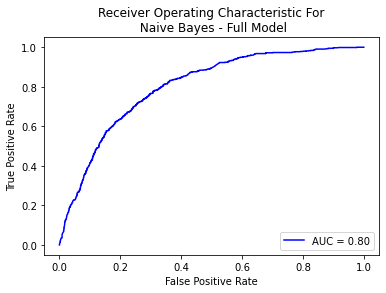

In [12]:
from sklearn import metrics

predict_prob = model.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Naive Bayes - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Logistic Regression - Full Model

The accuracy of the Logistic Regression model with all features is 0.781


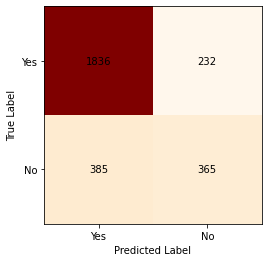

In [13]:
from sklearn import linear_model

# The full model with no variables removed - but all features have been 
# transformed into categorical features

from sklearn import linear_model
reg = linear_model.LogisticRegression()
reg.fit(train_X_cd, train_y_cd)
predictions = reg.predict(test_X_cd)

acc_fm_lr = reg.score(test_X_cd, test_y_cd)

print('The accuracy of the Logistic Regression model with all features is {}'.format(
    round(acc_fm_lr ,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

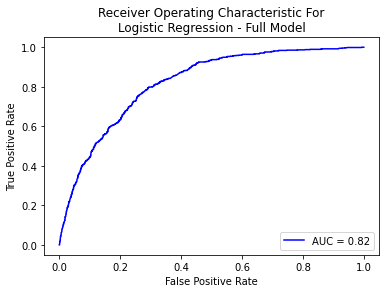

In [14]:
predict_prob = reg.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nLogistic Regression - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Decision Trees - Full Model

The accuracy of the test was 0.776


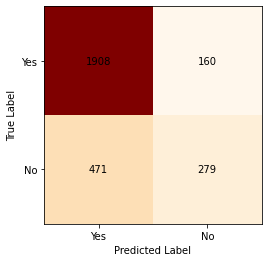

In [15]:
from sklearn.tree import DecisionTreeClassifier 

# Using a Decision tree with the maximum depth set to 4 to contrast with the above
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(train_X_cd, train_y_cd)

predictions = tree.predict(test_X_cd)

acc_fm_dt = tree.score(test_X_cd, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_fm_dt,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

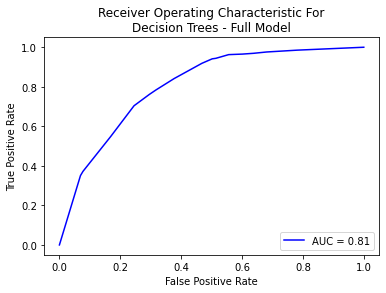

In [16]:
predict_prob = tree.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nDecision Trees - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Random Forests - Full Model

The accuracy of the test was 0.776


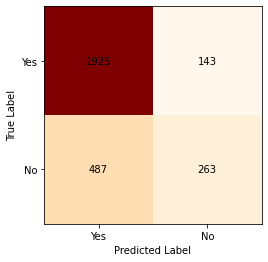

In [17]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(tree, n_estimators = 100, max_samples = 0.8, random_state = 1) # ensemble of many trees
bag.fit(train_X_cd, train_y_cd) # fit the ensemble to the data 

predictions = bag.predict(test_X_cd)

acc_fm_rf = bag.score(test_X_cd, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_fm_rf,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

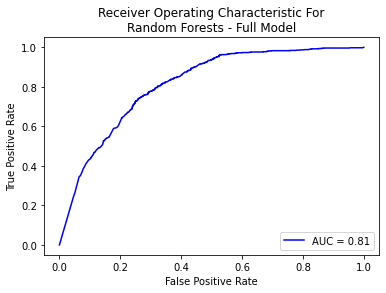

In [18]:
predict_prob = bag.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nRandom Forests - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

# Feature Selection using Chi-Square Test

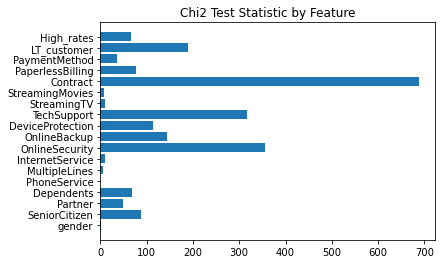

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Using chi2 to score features and select the k top features
# Set the selection criteria to k = 4 features selected using Chi2 
def chi2_features(train_X, train_y, test_X):
    select = SelectKBest(score_func=chi2, k=4)
    select.fit(train_X, train_y)
    train_X_selection = select.transform(train_X)
    test_X_selection = select.transform(test_X)
    return train_X_selection, test_X_selection, select

# Using the function above to select the most important features based on the chi2 criteria
# and assigning these arrays to be inputted into the logistic regression model
X_train_select, X_test_select, chi2_select = chi2_features(train_X_cd, train_y_cd, test_X_cd)

# Print statement giving the chi2 test statistics for each feature
#for i in range(len(chi2_select.scores_)):
#    print('The feature {} has a score of {}'.format(train_X.columns[i], round(chi2_select.scores_[i], 3)))

# Bar plot showing the test statistic for each feature
plt.barh([i for i in range(len(chi2_select.scores_))], chi2_select.scores_)
plt.yticks(range(18), train_X.columns)
plt.title('Chi2 Test Statistic by Feature');

### Naive Bayes

The accuracy of the test was 0.731


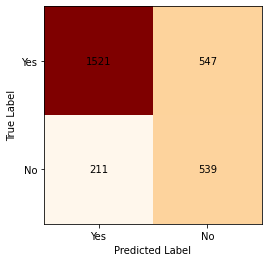

In [20]:
model = BernoulliNB()
model.fit(X_train_select, train_y_cd)
predictions = model.predict(X_test_select)

acc_chi_nb = model.score(X_test_select, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_chi_nb,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

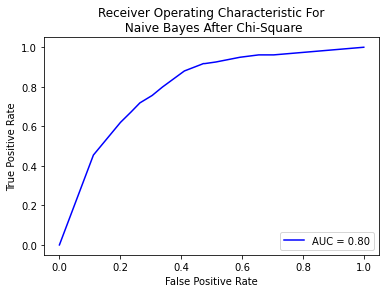

In [21]:
predict_prob = model.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Naive Bayes After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Logistic Regression

The accuracy of the test was 0.773 and the model included the features OnlineSecurity, TechSupport, Contract, LT_customer


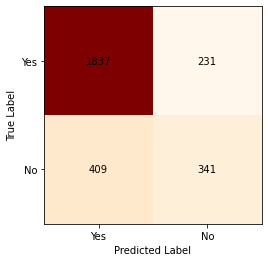

In [22]:
# Fit the logistic regression model
reg = linear_model.LogisticRegression()
reg.fit(X_train_select, train_y_cd)
predictions = reg.predict(X_test_select)

# Use the output of the function above create a dataframe of the selected features
features_c2 = chi2_select.get_support(indices=True)
features_c2_df = train_X.iloc[: ,features_c2]

# Print statement giving the accuracy of the model and which features were used

acc_chi_lr = reg.score(X_test_select, test_y_cd)

print('The accuracy of the test was {} and the model included the features {}'.format(
    round(acc_chi_lr ,3),
    ', '.join(features_c2_df.columns.values)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

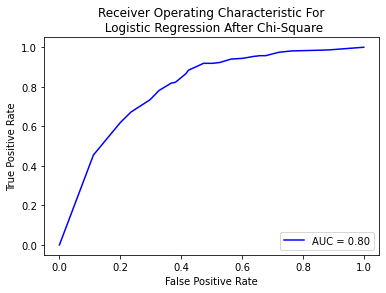

In [23]:
predict_prob = reg.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Logistic Regression After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Decision Tree

The accuracy of the test was 0.773


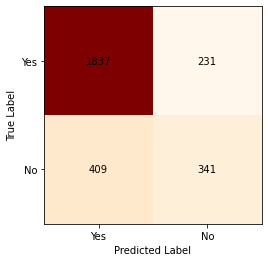

In [24]:
# Using a Decision tree with the maximum depth set to 4 to contrast with the above
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train_select, train_y_cd)

predictions = tree.predict(X_test_select)

acc_chi_dt = tree.score(X_test_select, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_chi_dt,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

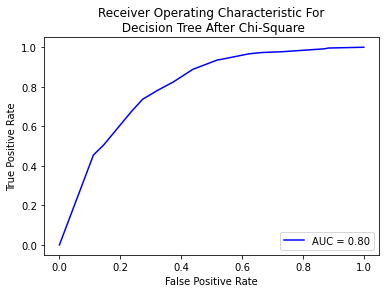

In [25]:
predict_prob = tree.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Decision Tree After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Random Forest 

The accuracy of the test was 0.773


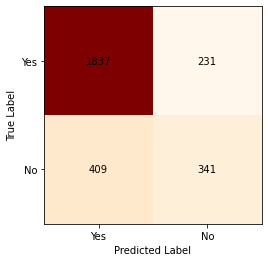

In [26]:
bag = BaggingClassifier(tree, n_estimators = 100, max_samples = 0.8, random_state = 1) # ensemble of many trees

bag.fit(X_train_select, train_y_cd) # fit the ensemble to the data 

predictions = bag.predict(X_test_select)

acc_chi_rf = bag.score(X_test_select, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_chi_rf,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

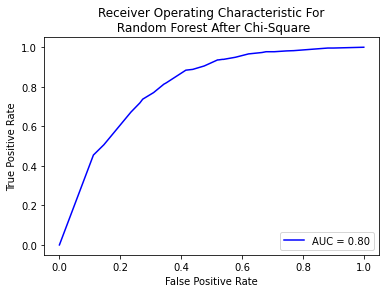

In [27]:
predict_prob = bag.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Random Forest After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

# Feature Selection using Mutual Information

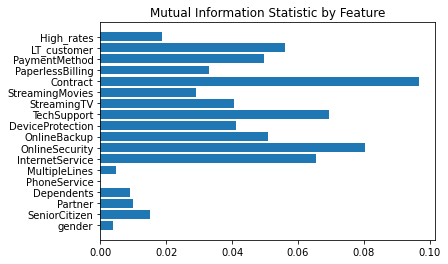

In [28]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score

#np.random.seed(10)
# Using mutual info classifier to score features and select the k top features
def mutualinfo_features(train_X, train_y, test_X):
    select = SelectKBest(score_func=mutual_info_classif, k=4)
    select.fit(train_X, train_y)
    train_X_selection = select.transform(train_X)
    test_X_selection = select.transform(test_X)
    return train_X_selection, test_X_selection, select

# Using the function above to select the most important features based on the mutual information criteria
# and assigning these arrays to be inputted into the logistic regression model
X_train_select, X_test_select, mi_select = mutualinfo_features(train_X_cd, train_y_cd, test_X_cd)

plt.barh([i for i in range(len(mi_select.scores_))], mi_select.scores_)
plt.yticks(range(18), train_X.columns)
plt.title('Mutual Information Statistic by Feature');


### Naive Bayes

The accuracy of the test was 0.752


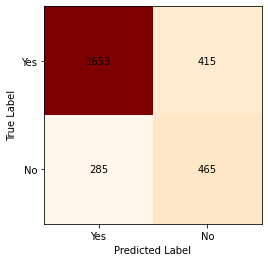

In [29]:
model = BernoulliNB()
model.fit(X_train_select, train_y_cd)
predictions = model.predict(X_test_select)

acc_mi_nb = model.score(X_test_select, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_mi_nb,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

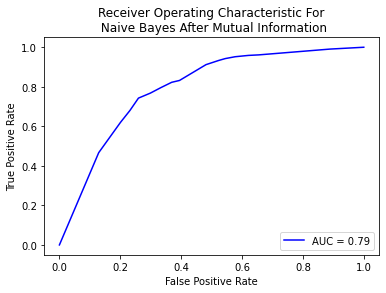

In [30]:
predict_prob = model.predict_proba(X_test_select)[::,1]

fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Naive Bayes After Mutual Information')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Logistic Regression

The accuracy of the test was 0.752 and the model included the features InternetService, OnlineSecurity, TechSupport, Contract


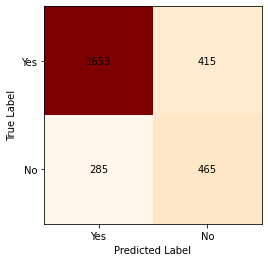

In [31]:
# Fit the logistic regression model
reg = linear_model.LogisticRegression()
reg.fit(X_train_select, train_y_cd)
predictions = reg.predict(X_test_select)

# Use the output of the function above create a dataframe of the selected features
features_mi = mi_select.get_support(indices=True)
features_mi_df = train_X.iloc[: ,features_mi]


acc_mi_lr = reg.score(X_test_select, test_y_cd)

# Print statement giving the accuracy of the model and which features were used
print('The accuracy of the test was {} and the model included the features {}'.format(
    round(acc_mi_lr,3),
    ', '.join(features_mi_df.columns.values)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

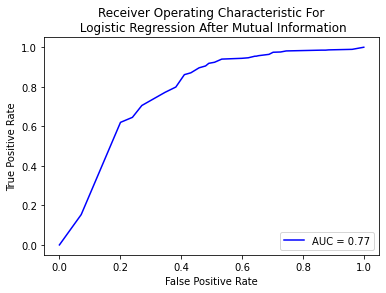

In [32]:
predict_prob = reg.predict_proba(X_test_select)[::,1]

fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Logistic Regression After Mutual Information')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Decision Trees

The accuracy of the test was 0.763


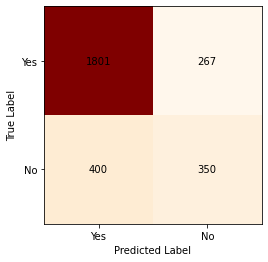

In [33]:
from sklearn.tree import DecisionTreeClassifier 

# Using a Decision tree with the maximum depth set to 4 to contrast with the above
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train_select, train_y_cd)

predictions = tree.predict(X_test_select)

acc_mi_dt = tree.score(X_test_select, test_y_cd)
print('The accuracy of the test was {}'.format(
    round(acc_mi_dt,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

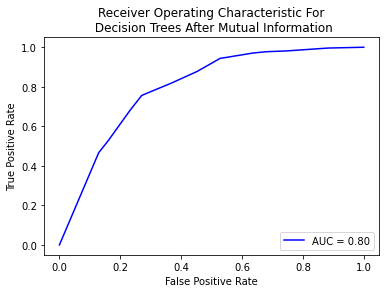

In [34]:
predict_prob = tree.predict_proba(X_test_select)[::,1]

fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Decision Trees After Mutual Information')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Random Forest

The accuracy of the test was 0.763


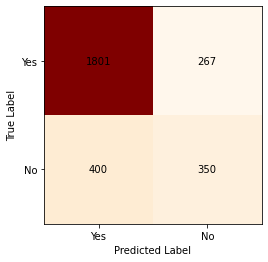

In [35]:
bag = BaggingClassifier(tree, n_estimators = 100, max_samples = 0.8, random_state = 1) # ensemble of many trees

bag.fit(X_train_select, train_y_cd) # fit the ensemble to the data 

predictions = bag.predict(X_test_select)

acc_mi_rf = bag.score(X_test_select, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_mi_rf,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

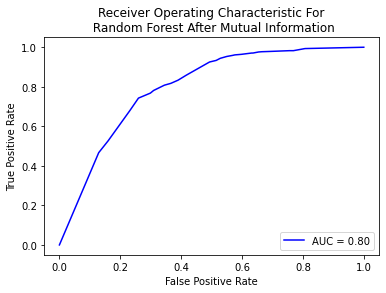

In [36]:
predict_prob = bag.predict_proba(X_test_select)[::,1]

fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Random Forest After Mutual Information')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

In [37]:
pd.DataFrame([[acc_fm_nb, acc_fm_lr, acc_fm_dt, acc_fm_rf],
            [acc_chi_nb, acc_chi_lr, acc_chi_dt, acc_chi_rf],
            [acc_mi_nb, acc_mi_lr, acc_mi_dt, acc_mi_rf]], 
             index = ['Full Model', 'Chi2 Criteria', 'Mutual Information'],
            columns = ['Naive Bayes', 'Logistic Regression', 'Decision Trees', 'Random Forests'])

,Naive Bayes,Logistic Regression,Decision Trees,Random Forests
Full Model,0.740951,0.781050,0.776082,0.776437
Chi2 Criteria,0.731015,0.772889,0.772889,0.772889
Mutual Information,0.751597,0.751597,0.763307,0.763307
